## Sky Radiance distribution

P. Lewis

![Solaris](movie.gif "Solaris")



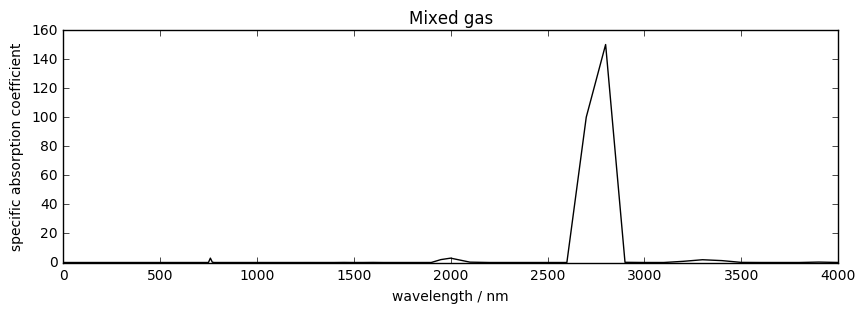

In [1]:
import numpy as np
import pylab as plt
import scipy.interpolate

%matplotlib inline


class Rayleigh(object):
    def __init__(self, A=None,B=None,C=None,D=None,Kg=None):
        '''
        A,B,C,D see [Frohlich & Shaw, 1980, p. 1775]

        Defaults:
        A=0.00838
        B=3.916
        C=0.074
        D=0.050

        Kg:  effective absorption coefficient of
             uniformly-mixed gasses tabular data [Leckner,1978]
             
             Must be:
             
             a) 2d array of shape (2,ns) where the first column of
                data self.Kg[0] is wavelength and the second self.Kg[1]
                the specific abs coeff of mixed gas
             OR
             b) 1d array of shape (nl) to match the wavelengths that will be used
                (but need not be defined or stored in here)
             
        '''
        
        datastr =  ''' 0 0
        400  0.0        500 0.0        750 0.0       760  0.300E+01 770  0.210E+00 
        780  0.0       1240 0.0       1250 0.730E-02 1300 0.400E-03 1350 0.110E-03
        1400 0.100E-04 1450 0.640E-01 1500 0.630E-03 1550 0.100E-01 1600 0.640E-01
        1650 0.145E-02 1700 0.100E-04 1750 0.100E-04 1800 0.100E-04 1850 0.145E-03
        1900 0.710E-02 1950 0.200E+01 2000 0.300E+01 2100 0.240E+00 2200 0.380E-03 
        2300 0.110E-02 2400 0.170E-03 2500 0.140E-03 2600 0.660E-03 2700 0.100E+03 
        2800 0.150E+03 2900 0.130E+00 3000 0.950E-02 3100 0.100E-02 3200 0.800E+00 
        3300 0.190E+01 3400 0.130E+01 3500 0.750E-01 3600 0.100E-01 3700 0.195E-02 
        3800 0.400E-02 3900 0.290E+00 4000 0.250E-01'''
        
        ADefault = 0.00838
        BDefault = 3.916
        CDefault = 0.074
        DDefault = 0.050

        self.A = A or ADefault
        self.B = B or BDefault
        self.C = C or CDefault
        self.D = D or DDefault
        
        self.data = np.array(datastr.split()).astype(float)
        l = len(self.data)
        self.data = self.data.reshape((l/2,2)).T
        
    
        self.Kg = self.KgOrig = Kg or self.data
        # dont form self.Kg as 1d dataset
        # until wavelength defined, then do
        # if self.Kg is 2D ... taking from
        # self.KgOrig
        
        
    def scaleHeight(self,height):
        '''
        Rayleigh vapour scale height [Guzzi et al., 1987]

        Note: height can be scalar, or array-like of 1 or 2 heights

        '''
        height = np.atleast_1d(height)
        sh = np.exp(-(0.1188*height + 0.00116*height*height))
        if len(height) == 2:
            sh = np.abs(sh[0]-sh[1]) 
        return sh

    def Phase(self,cos2t):
        '''
         cos2t -> cos^2(phase)

        '''
        out = 0.75*(1.0+cos2t)
        return(out)
    
def main():
    r=Rayleigh()
    plt.figure(figsize=(10,3))
    plt.plot(r.Kg[0],r.Kg[1],'k')
    plt.xlabel('wavelength / nm')
    plt.ylabel('specific absorption coefficient')
    plt.title('Mixed gas')

if __name__ == "__main__":
    main()

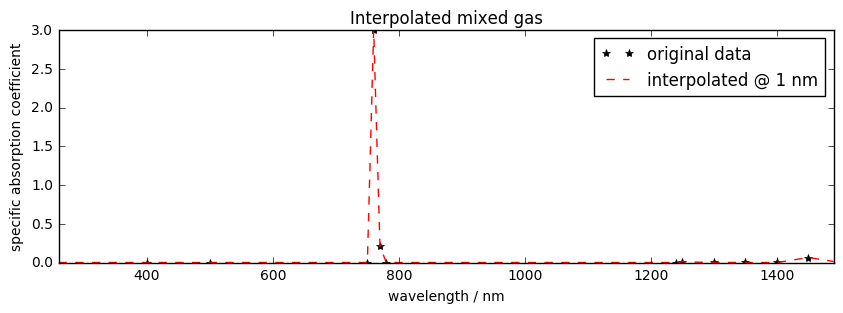

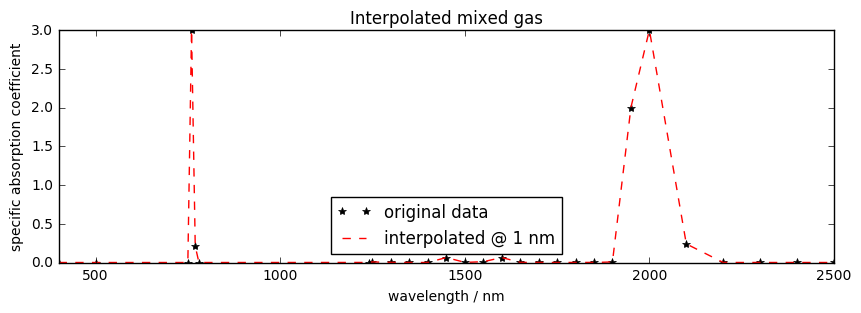

In [2]:
class Lambda(object):
    '''
      Wavelength class (nm)

      Options:
      --------

    1. Angular resolution

      angres = (2.,2.)             : theta, phi angular resolution (degrees)

    2. wavelengths

      To initiate wavelengths use 

      EITHER

        wl=(400.,2500.,1.)         : as wlStart, wlEnd, wlStep

      OR

        wavelengths=[400,300,200]  : as particular wavelengths

    '''
    def __init__(self,wl=(),wavelengths=[],angres=()):

        default = (400.,2500.,1.)
        defaultAngres = (2.,2.)

        if len(wavelengths) == 0:
            self.wl = wl + default[len(wl):]
            self.l = np.arange(*self.wl).astype(float)
        else:
            self.l = np.array(wavelengths).astype(float)
        self.nb = len(self.l)
        self.angres = angres + defaultAngres[len(angres):]
        
        # image rows and columns for output
        self.rows=(int)(90.0/self.angres[0] + 0.5) + 1
        self.cols=(int)(360.0/self.angres[1] + 0.5) + 1
        self.frames = self.nb

    
def main():
    
    for LambdaCoefs in [{'wl':(260.,1500,10),'wavelengths':[],'angres':()},\
                        {'wl':(),'wavelengths':[],'angres':()}]:

        r=Rayleigh()
        plt.figure(figsize=(10,3))
        plt.plot(r.KgOrig[0],r.KgOrig[1],'k*',label='original data')
        l=Lambda(**LambdaCoefs)
        f = scipy.interpolate.interp1d(r.KgOrig[0],r.KgOrig[1])
        r.Kg = f(l.l)
        #plt.semilogy()
        plt.plot(l.l,r.Kg,'r--',label='interpolated @ 1 nm')
        plt.xlabel('wavelength / nm')
        plt.ylabel('specific absorption coefficient')
        plt.title('Interpolated mixed gas')
        plt.xlim(l.l[0],l.l[-1])
        plt.ylim(0,r.Kg.max())
        plt.legend(loc='best')
 
if __name__ == "__main__":
    main()

In [3]:
TTHGCoefs={'g1':None,'g2':None,'alpha':None}

class TTHG(object):

    def __init__(self,g1=None,g2=None,alpha=None):

        '''
        Two term Henyey Greenstein phase function

        note that we expect g1 to be +ve (forward scattering)
        and g2 -ve (back scattering)

        Parameters:

            g1     = 0.713      :   [Kattawar,]
            g2     = -0.7598
            alpha  = 0.9618   
        '''
        g1Default     = 0.713 
        g2Default     = -0.7598
        alphaDefault  = 0.9618             

        self.g1 = g1 or g1Default
        self.g2 = g2 or g2Default
        self.alpha = alpha or alphaDefault

    def PhaseHG(self,g,cost,sign):
        '''
        HG phase function
        '''
        g2=g*g

        out=(1.0-g2)/((1.0 + g2 + sign*(2.0*g*cost))**1.5)

        return(out)

    def Phase(self,cost):
        '''
        TTHG phase function

        note that we expect g1 to be +ve (forward scattering)
        and g2 -ve (back scattering)
        '''
        g12=self.g1*self.g1;
        g22=self.g2*self.g2;

        numer1=self.alpha*(1.0-g12)
        numer2=(1.0-self.alpha)*(1.0-g22)
        denom1=((1.0+g12-(2.0*self.g1*cost))**1.5)
        denom2=((1.0+g22-(2.0*self.g2*cost))**1.5)
        out=(numer1/denom1)+(numer2/denom2)
        return(out)

def main():
    tthg = TTHG(**TTHGCoefs)
    print 'done'

if __name__ == "__main__":
    main()

done


In [4]:
class Aerosol(object):

    def __init__(self,omega_A=None,alpha=None,beta=None,H_Penndorf=None):

        '''

        Aerosol class

        Options:

        omega_A    : Aerosol single-scattering albedo
        alpha      : Angstrom wavelength exponent
        beta       : Angstrom turbidity coefficient
        H_Penndorf : Penndorf scale height parameter

        Aerosol single-scattering albedo:    
             0.6 -> urban / industrial            
             0.9 -> continental                   
             1.0 -> maritime (pure scattering)    

             Default: 0.9 [Deepak & Gerber, 1983]

        alpha: Angstrom wavelength exponent:        
             generally in the range 0.5-1.6       
             though can be less for polluted      
             atmosphere.                          
             av. conditions: alpha = 1.3 +/- 0.2  

             Default:  1.3     [Angstrom, 1961]

        beta: Angstrom turbidity coefficient:
             [Leckner, 1978]:                     
              lat: | 60N   | 45N   | 30N   | 0     
              -------------------------------------
              low  | 0.01  | 0.047 | 0.047 | 0.047 
              med  | 0.057 | 0.077 | 0.097 | 0.117 
              high | 0.093 | 0.187 | 0.375 | 0.375 

              generally peaks in summer.           
              average mean values given by         
              [Angstrom, 1961]:                    

              beta=[0.025+0.1cos^2(lat)]exp(-0.7h) 

               h    - height in km                  
               lat  - latitude        

              Default:  0.1     [Angstrom, 1961]

         H_Penndorf:  Penndorf scale height parameter 
                      Default: 0.97   [Guzzi et al., 1987]
        '''
        omega_ADefault    = 0.9    # [Deepak & Gerber, 1983]
        alphaDefault      = 1.3    # [Angstrom, 1961]
        betaDefault       = 0.1    # [Angstrom, 1961]
        H_PenndorfDefault = 0.97   # [Guzzi et al., 1987]
        self.omega_A    =  omega_A or omega_ADefault
        self.alpha      =  alpha or alphaDefault
        self.beta       =  beta or betaDefault
        self.H_Penndorf = H_Penndorf or H_PenndorfDefault

    def scaleHeight(self,height):
        '''
        Aerosol scale height [Guzzi et al., 1987]

        Note: height can be scalar, or array-like of 1 or 2 heights

        Uses self.H_Penndorf

        '''
        height = np.atleast_1d(height)
        sh = np.exp(-(height/self.H_Penndorf))
        if len(height) == 2:
            sh = np.abs(sh[0]-sh[1]) 
        return sh

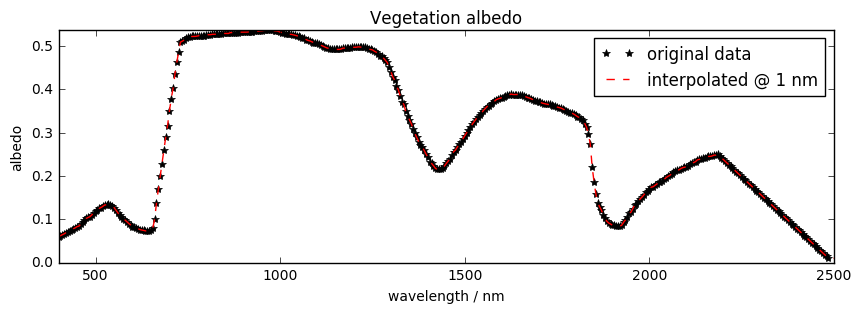

In [5]:
AlbedoCoefs={'albedo':None}

class Albedo(object):
    def __init__(self,albedo=None):
        '''
        set surface albedo for multiple scattering interactions
        
        # 
        # VEGETATION AVERAGE REFLECTANCE 
        # WARNING : VALUES OF DRY SAND GROUND REFLECTANCE ARE GIVEN 
        # BETWEEN 0.4 AND 2.2 MICRONS. OUTSIDE THIS INTERVAL THE 
        # VALUES ARE SET TO 0. 
        # 
        # 
        #	column1:	wavelength / nm
        #	column2:	'mean' reflectance
        #
        # 	data source: 5S source code 
        #
        #	data processed by:
        #		Lewis, Dept. Geog., UCL
        #		Tue Mar 16 1993
        #
        #
        '''
        datastr = ''' 0 0
         250 0.000   
         390 0.000   395 0.060   400 0.060   405 0.062   410 0.064   415 0.066   420 0.069   
         425 0.070   430 0.072   435 0.074   440 0.078   445 0.080   450 0.083   455 0.084   
         460 0.089   465 0.093   470 0.098   475 0.102   480 0.104   485 0.106   490 0.110   
         495 0.115   500 0.119   505 0.121   510 0.125   515 0.127   520 0.130   525 0.133   
         530 0.133   535 0.134   540 0.133   545 0.131   550 0.127   555 0.121   560 0.115   
         565 0.110   570 0.105   575 0.101   580 0.098   585 0.094   590 0.090   595 0.087   
         600 0.083   605 0.081   610 0.080   615 0.078   620 0.076   625 0.075   630 0.074   
         635 0.073   640 0.073   645 0.073   650 0.074   655 0.079   660 0.100   665 0.138   
         670 0.169   675 0.199   680 0.228   685 0.259   690 0.290   695 0.316   700 0.350   
         705 0.378   710 0.403   715 0.436   720 0.462   725 0.487   730 0.509   735 0.511   
         740 0.514   745 0.519   750 0.520   755 0.520   760 0.522   765 0.522   770 0.522   
         775 0.523   780 0.524   785 0.524   790 0.524   795 0.524   800 0.526   805 0.526   
         810 0.526   815 0.527   820 0.527   825 0.527   830 0.528   835 0.528   840 0.528   
         845 0.529   850 0.529   855 0.529   860 0.529   865 0.531   870 0.531   875 0.531  
         880 0.531   885 0.531   890 0.532   895 0.532   900 0.532   905 0.532   910 0.532  
         915 0.533   920 0.533   925 0.533   930 0.534   935 0.534   940 0.534   945 0.535  
         950 0.535   955 0.536   960 0.536   965 0.537   970 0.537   975 0.536   980 0.536  
         985 0.535   990 0.535   995 0.534  1000 0.532  1005 0.531  1010 0.530  1015 0.528 
        1020 0.528  1025 0.527  1030 0.527  1035 0.526  1040 0.525  1045 0.524  1050 0.522 
        1055 0.521  1060 0.519  1065 0.518  1070 0.515  1075 0.513  1080 0.512  1085 0.510  
        1090 0.508  1095 0.507  1100 0.506  1105 0.505  1110 0.502  1115 0.500  1120 0.498  
        1125 0.496  1130 0.495  1135 0.493  1140 0.492  1145 0.492  1150 0.492  1155 0.492  
        1160 0.492  1165 0.493  1170 0.495  1175 0.495  1180 0.496  1185 0.496  1190 0.496  
        1195 0.497  1200 0.497  1205 0.497  1210 0.498  1215 0.498  1220 0.497  1225 0.497  
        1230 0.497  1235 0.495  1240 0.493  1245 0.492  1250 0.491  1255 0.488  1260 0.486  
        1265 0.482  1270 0.478  1275 0.476  1280 0.472  1285 0.467  1290 0.462  1295 0.451  
        1300 0.441  1305 0.429  1310 0.421  1315 0.408  1320 0.399  1325 0.385  1330 0.371  
        1335 0.365  1340 0.349  1345 0.339  1350 0.330  1355 0.321  1360 0.309  1365 0.298  
        1370 0.289  1375 0.279  1380 0.272  1385 0.267  1390 0.259  1395 0.251  1400 0.243  
        1405 0.233  1410 0.229  1415 0.224  1420 0.218  1425 0.215  1430 0.215  1435 0.215  
        1440 0.219  1445 0.223  1450 0.229  1455 0.234  1460 0.240  1465 0.249  1470 0.256  
        1475 0.260  1480 0.267  1485 0.273  1490 0.279  1495 0.286  1500 0.293  1505 0.300  
        1510 0.306  1515 0.312  1520 0.319  1525 0.325  1530 0.331  1535 0.337  1540 0.341  
        1545 0.345  1550 0.351  1555 0.355  1560 0.360  1565 0.362  1570 0.367  1575 0.369  
        1580 0.372  1585 0.376  1590 0.378  1595 0.379  1600 0.381  1605 0.382  1610 0.384  
        1615 0.386  1620 0.387  1625 0.389  1630 0.388  1635 0.388  1640 0.388  1645 0.388  
        1650 0.388  1655 0.388  1660 0.384  1665 0.383  1670 0.381  1675 0.380  1680 0.378  
        1685 0.376  1690 0.374  1695 0.373  1700 0.371  1705 0.370  1710 0.368  1715 0.367  
        1720 0.366  1725 0.365  1730 0.365  1735 0.363  1740 0.362  1745 0.361  1750 0.359  
        1755 0.358  1760 0.357  1765 0.355  1770 0.353  1775 0.350  1780 0.347  1785 0.346  
        1790 0.345  1795 0.343  1800 0.340  1805 0.337  1810 0.335  1815 0.331  1820 0.330  
        1825 0.321  1830 0.312  1835 0.296  1840 0.273  1845 0.221  1850 0.186  1855 0.158  
        1860 0.138  1865 0.129  1870 0.121  1875 0.110  1880 0.102  1885 0.095  1890 0.091  
        1895 0.089  1900 0.086  1905 0.086  1910 0.084  1915 0.084  1920 0.084  1925 0.086  
        1930 0.093  1935 0.098  1940 0.105  1945 0.114  1950 0.116  1955 0.124  1960 0.133  
        1965 0.134  1970 0.141  1975 0.147  1980 0.151  1985 0.156  1990 0.162  1995 0.166  
        2000 0.170  2005 0.174  2010 0.175  2015 0.178  2020 0.181  2025 0.185  2030 0.187  
        2035 0.188  2040 0.192  2045 0.196  2050 0.199  2055 0.201  2060 0.205  2065 0.208  
        2070 0.212  2075 0.213  2080 0.214  2085 0.217  2090 0.219  2095 0.220  2100 0.221  
        2105 0.224  2110 0.227  2115 0.229  2120 0.231  2125 0.233  2130 0.237  2135 0.238  
        2140 0.239  2145 0.241  2150 0.242  2155 0.243  2160 0.245  2165 0.245  2170 0.246  
        2175 0.248  2180 0.248  2185 0.250  2190 0.246  2195 0.242  2200 0.238  2205 0.234  
        2210 0.230  2215 0.226  2220 0.222  2225 0.218  2230 0.214  2235 0.210  2240 0.206  
        2245 0.202  2250 0.198  2255 0.194  2260 0.190  2265 0.186  2270 0.182  2275 0.178 
        2280 0.174  2285 0.170  2290 0.166  2295 0.162  2300 0.158  2305 0.154  2310 0.150  
        2315 0.146  2320 0.142  2325 0.138  2330 0.134  2335 0.130  2340 0.126  2345 0.122  
        2350 0.118  2355 0.114  2360 0.110  2365 0.106  2370 0.102  2375 0.098  2380 0.094  
        2385 0.090  2390 0.086  2395 0.082  2400 0.078  2405 0.074  2410 0.070  2415 0.066  
        2420 0.062  2425 0.058  2430 0.054  2435 0.050  2440 0.046  2445 0.042  2450 0.038  
        2455 0.034  2460 0.030  2465 0.026  2470 0.022  2475 0.018  2480 0.014  2485 0.010  
        2580 0.010  2585 0.000   
        4000 0.000
        '''
        
        
        self.data = np.array(datastr.split()).astype(float)
        l = len(self.data)
        self.data = self.data.reshape((l/2,2)).T
        self.albedo = self.albedoOrig = albedo or self.data        

    
def main():
    r=Albedo(**AlbedoCoefs)
    plt.figure(figsize=(10,3))
    plt.plot(r.albedoOrig[0],r.albedoOrig[1],'k*',label='original data')
    l=Lambda()
    f = scipy.interpolate.interp1d(r.albedoOrig[0],r.albedoOrig[1])
    r.albedo = f(l.l)
    #plt.semilogy()
    plt.plot(l.l,r.albedo,'r--',label='interpolated @ 1 nm')
    plt.xlabel('wavelength / nm')
    plt.ylabel('albedo')
    plt.title('Vegetation albedo')
    plt.xlim(l.l[0],l.l[-1])
    plt.ylim(0,r.albedo.max())
    plt.legend(loc='best')

if __name__ == "__main__":
    main()

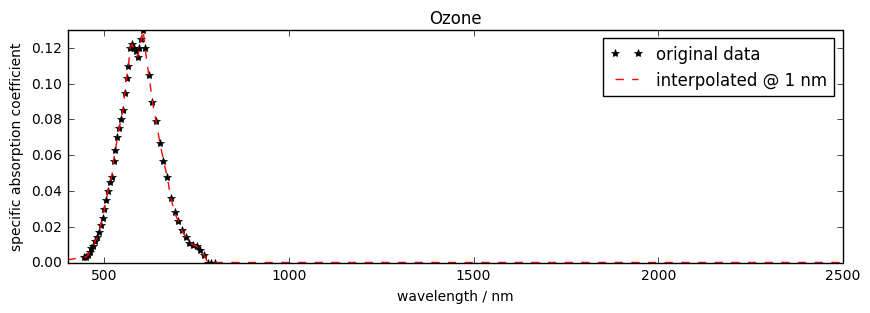

In [6]:
OzoneCoefs={'Co3':None,'b':None,'c':None,'Ko3':None}                   

class Ozone(object):
    def __init__(self,Co3=None,b=None,c=None,Ko3=None):
        '''
        Co3:    ozone concentration (cm NTP)         
                typically, 0.4 cm                    
                usually in the range [0.2,0.6]     
                Default 0.3

        Ko3:    Spectral Absorption coefficient     
                of Ozone (cm^-1)                    
        b,c:    Ozone scale height parameters            
                    b: altitude (knm) at which ozone conc. is max. 
                       Default 20 [Guzzi et al., 1987]
                    c: ratio of maximum ozone conc. to       
                       total ozone amount     
                       Default 5 [Guzzi et al., 1987]
        '''
        Co3Default = 0.3    # [Leckner, 1978]
        bDefault   = 20.    # [Guzzi et al., 1987]
        cDefault   = 5.     # [Guzzi et al., 1987]

        self.Co3 = Co3 or Co3Default
        self.b   = b or bDefault
        self.c   = c or cDefault
        
        datastr = ''' 0 0
        290 38.000   295 20.000   300 10.000   305 4.800   310 2.700   315 1.350   320 0.800   
        325 0.380   330 0.160   335 0.075   340 0.040   345 0.019   350 0.007   355 0.000   
        445 0.003   450 0.003   455 0.004   460 0.006   465 0.008   470 0.009   475 0.012   
        480 0.014   485 0.017   490 0.021   495 0.025   500 0.030   505 0.035   510 0.040   
        515 0.045   520 0.048   525 0.057   530 0.063   535 0.070   540 0.075   545 0.080   
        550 0.085   555 0.095   560 0.103   565 0.110   570 0.120   575 0.122   580 0.120   
        585 0.118   590 0.115   595 0.120   600 0.125   605 0.130   610 0.120   620 0.105   
        630 0.090   640 0.079   650 0.067   660 0.057   670 0.048   680 0.036   690 0.028   
        700 0.023   710 0.018   720 0.014   730 0.011   740 0.010   750 0.009   760 0.007   
        770 0.004   780 0.000   790 0.000   800 0.000  3000 0.000'''
        
        
        self.data = np.array(datastr.split()).astype(float)
        l = len(self.data)
        self.data = self.data.reshape((l/2,2)).T
        self.Ko3 = self.Ko3Orig = Ko3 or self.data 
        
    def scaleHeight(self,height):
        '''
        Ozone vapour scale height [Guzzi et al., 1987] [Lacis and Hansen, 1974]

        Note: height can be scalar, or array-like of 1 or 2 heights

        '''
        height = np.atleast_1d(height)
        sh = (1.0 + np.exp(-self.b/self.c))/(1.0+np.exp((height-self.b)/self.c))
        if len(height) == 2:
            sh = np.abs(sh[0]-sh[1]) 
        return sh

def main():
    r=Ozone(**OzoneCoefs)
    plt.figure(figsize=(10,3))
    plt.plot(r.Ko3Orig[0],r.Ko3Orig[1],'k*',label='original data')
    l=Lambda()
    f = scipy.interpolate.interp1d(r.Ko3Orig[0],r.Ko3Orig[1])
    r.Ko3 = f(l.l)
    #plt.semilogy()
    plt.plot(l.l,r.Ko3,'r--',label='interpolated @ 1 nm')
    plt.xlabel('wavelength / nm')
    plt.ylabel('specific absorption coefficient')
    plt.title('Ozone')
    plt.xlim(l.l[0],l.l[-1])
    plt.ylim(0,r.Ko3.max())
    plt.legend(loc='best')

if __name__ == "__main__":
    main()

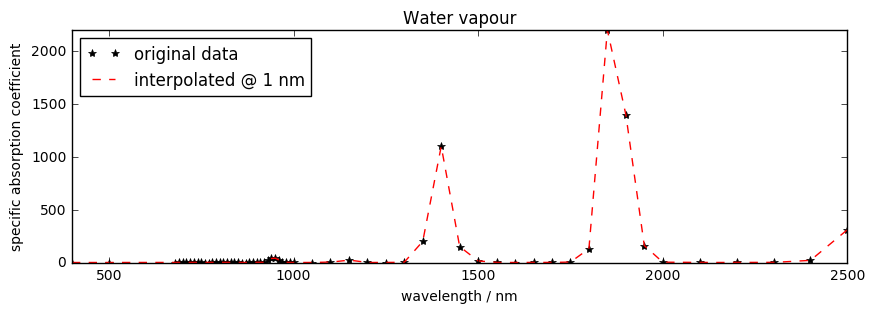

In [7]:
WaterVapourCoefs={'Cw':None,'beta_0':None,'Td':None,'Kw':None}

class WaterVapour(object):
    def __init__(self,Cw=None,beta_0=None,Td=None,Kw=None):
        '''
        Cw:     Precipitable water content of atm. (cm)
                [Leckner, 1978]: 

                     lat.            Cw              
                -------------------------------------
                     15N             4.1             
                     45N (summer)    2.9
                     45N (winter)    0.9
                     60N (summer)    2.1 
                     60N (winter)    0.4
                     US62            1.4 

                or [Leckner, 1978]: 
                Cw = 181 density_W(0) / 0.795

                for standard atmosphere 
                density_w = phi * Ps / (R * T(0))    

                phi - relative humidity (fractional) 
                R - Gas constant (461.51)            
                T(0) - absolute temperature (K)      
                Ps - water vapour saturation pressure
                Over water,                          
                Ps = exp(-5416/T(0) + 26.23) (Pa)    

                other sources: e.g.                  
                [Science data book, 1979]            
                or other tables of thermal data

        Kw:     spectral absorption coefficient of water (cm-1) 
                tabular data [Leckner,1978]

        beta_0: water vapour scale height parameter

                beta_0 = exp(-(ln(Cw)-0.061Td)+0.715)
                               _____________________
                               (       0.983         )
        Td:     dew point temperature (C) [10.02]

        '''
        TdDefault = 10.02  # [Leckner, 1978]
        CwDefault = 1.4    # [Leckner, 1978]    
        beta_0Default = None

        self.Cw     = CwDefault
        self.beta_0 = beta_0 or beta_0Default
        self.Td     = Td or TdDefault
        
        datastr = ''' 0 0
        400 0.000   500 0.000   680 0.000   690 0.016   700 0.024   710 0.013   
        720 1.000   730 0.870   740 0.061   750 0.001   760 0.000   770 0.000   
        780 0.001   790 0.018   800 0.036   810 0.330   820 1.530   830 0.660   
        840 0.155   850 0.003   860 0.000   870 0.000   880 0.003   890 0.063   
        900 2.100   910 1.600   920 1.250   930 27.000   940 38.000   950 41.000   
        960 26.000   970 3.100   980 1.480   990 0.125  1000 0.003  1050 0.000  
        1100 3.200  1150 23.000  1200 0.016  1250 0.000  1300 2.900  1350 200.000  
        1400 1100.000  1450 150.000  1500 15.000  1550 0.002  1600 0.000  1650 0.010  
        1700 0.510  1750 4.000  1800 130.000  1850 2200.000  1900 1400.000  1950 160.000  
        2000 2.900  2100 0.220  2200 0.330  2300 0.590  2400 20.300  2500 310.000  2600 
        15000.000  2700 22000.000  2800 8000.000  2900 650.000  3000 240.000  
        3100 230.000  3200 100.000  3300 120.000  3400 19.500  3500 3.600  
        3600 3.100  3700 2.500  3800 1.400  3900 0.170  4000 0.004
        '''
        
        self.data = np.array(datastr.split()).astype(float)
        l = len(self.data)
        self.data = self.data.reshape((l/2,2)).T
        self.Kw = self.KwOrig = Kw or self.data         

        if self.Cw != 0.0:
            self.beta_0 = np.exp(-(np.log(self.Cw) - 0.061*self.Td + 0.715)/0.983)
        else:
            self.beta_0 = 0.0

    def scaleHeight(self,height):
        '''
        Water vapour scale height [Guzzi et al., 1987]

        Note: height can be scalar, or array-like of 1 or 2 heights

        '''
        height = np.atleast_1d(height)
        sh = np.exp(-self.beta_0*height)
        if len(height) == 2:
            sh = np.abs(sh[0]-sh[1]) 
        return sh
    
def main():
    r=WaterVapour(**WaterVapourCoefs)
    plt.figure(figsize=(10,3))
    plt.plot(r.KwOrig[0],r.KwOrig[1],'k*',label='original data')
    l=Lambda()
    f = scipy.interpolate.interp1d(r.KwOrig[0],r.KwOrig[1])
    r.Kw = f(l.l)
    #plt.semilogy()
    plt.plot(l.l,r.Kw,'r--',label='interpolated @ 1 nm')
    plt.xlabel('wavelength / nm')
    plt.ylabel('specific absorption coefficient')
    plt.title('Water vapour')
    plt.xlim(l.l[0],l.l[-1])
    plt.ylim(0,r.Kw.max())
    plt.legend(loc='best')

if __name__ == "__main__":
    main()

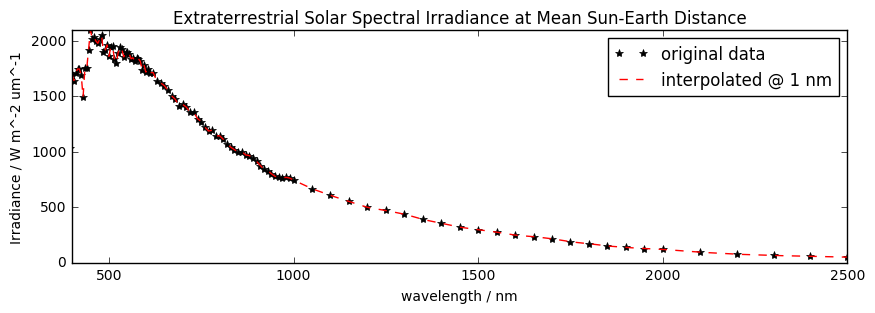

In [8]:
EODCoefs={'EOD':None}

class EOD(object):
    def __init__(self,EOD=None):
        '''
        EOD:  Illumination data at TOA
        
        		The Solar Constant and Its Spectral Distribution
    
                                     Table 3.3.2

          Extraterrestrial Solar Spectral Irradiance at Mean Sun-Earth Distance ( WRC spectrum)a,b

          lambda (microns)  I sub(O.n.lambda) (W m^-2 um^-1)
          lambda now in nm

        '''
        datastr = ''' 0 0
        250 64.560   255 91.250   260 122.500   265 253.750   270 275.000   275 212.500   
        280 162.500   285 286.250   290 535.000   295 560.000   300 527.500   305 557.500   
        310 602.510   315 705.000   320 747.500   325 782.500   330 997.500   335 906.250   
        340 960.000   345 877.500   350 955.000   350 955.000   355 1044.990   360 940.000   
        365 1125.010   370 1165.000   375 1081.250   380 1210.000   385 931.250   390 1200.000   
        395 1033.740   400 1702.490   405 1643.750   410 1710.000   415 1747.500   420 1747.500   
        425 1692.510   430 1492.500   435 1761.250   440 1755.020   445 1922.490   450 2099.990   
        455 2017.510   460 2032.490   465 2000.000   470 1979.990   475 2016.250   480 2055.000   
        485 1901.260   490 1920.000   495 1965.000   500 1862.520   505 1943.750   510 1952.500   
        515 1835.010   520 1802.490   525 1894.990   530 1947.490   535 1926.240   540 1857.500   
        545 1895.010   550 1902.500   555 1885.000   560 1840.020   565 1850.000   570 1817.500   
        575 1848.760   580 1840.000   585 1817.500   590 1742.490   595 1785.000   600 1720.000   
        605 1751.250   610 1715.000   620 1715.000   630 1637.500   640 1622.500   650 1597.500   
        660 1555.000   670 1505.000   680 1472.500   690 1415.020   700 1427.500   710 1402.500   
        720 1355.000   730 1355.000   740 1300.000   750 1272.520   760 1222.500   770 1187.500   
        780 1195.000   790 1142.500   800 1144.700   810 1113.000   820 1070.000   830 1041.000   
        840 1019.990   850 994.000   860 1002.000   870 972.000   880 966.000   890 945.000   
        900 913.000   910 876.000   920 841.000   930 830.000   940 801.000   950 778.000   
        960 771.000   970 764.000   980 769.000   990 762.000  1000 743.990  1050 665.980  
        1100 606.040  1150 551.040  1200 497.990  1250 469.990  1300 436.990  1350 389.030  
        1400 354.030  1450 318.990  1500 296.990  1550 273.990  1600 247.020  1650 234.020  
        1700 215.000  1750 187.000  1800 170.000  1850 149.010  1900 136.010  1950 126.000  
        2000 118.500  2100 93.000  2200 74.750  2300 63.250  2400 56.500  2500 48.250  
        2600 42.000  2700 36.500  2800 32.000  2900 28.000  3000 24.750  3100 21.750  
        3200 19.750  3300 17.250  3400 15.750  3500 14.000  3600 12.750  3700 11.500  
        3800 10.500  3900 9.500  4000 8.500  4100 7.750  4200 7.000  4300 6.500  4400 6.000  
        4500 5.500  4600 5.000  4700 4.500  4800 4.000  4900 3.750  5000 3.470  6000 1.750  
        7000 0.950  8000 0.550  9000 0.350 10000 0.200 25000 0.120'''
        
        self.data = np.array(datastr.split()).astype(float)
        l = len(self.data)
        self.data = self.data.reshape((l/2,2)).T
        self.EOD = self.EODOrig = EOD or self.data         


def main():
    r=EOD(**EODCoefs)
    plt.figure(figsize=(10,3))
    plt.plot(r.EODOrig[0],r.EODOrig[1],'k*',label='original data')
    l=Lambda()
    f = scipy.interpolate.interp1d(r.EODOrig[0],r.EODOrig[1])
    r.EOD = f(l.l)
    #plt.semilogy()
    plt.plot(l.l,r.EOD,'r--',label='interpolated @ 1 nm')
    plt.xlabel('wavelength / nm')
    plt.ylabel('Irradiance / W m^-2 um^-1')
    plt.title('Extraterrestrial Solar Spectral Irradiance at Mean Sun-Earth Distance')
    plt.xlim(l.l[0],l.l[-1])
    plt.ylim(0,r.EOD.max())
    plt.legend(loc='best')

if __name__ == "__main__":
    main()

compare Rayleigh with "Frohlich and Shaw, p. 1774 APPLIED OPTICS/ Vol. 19, No. 11 / 1 June 1980"
91 361 42


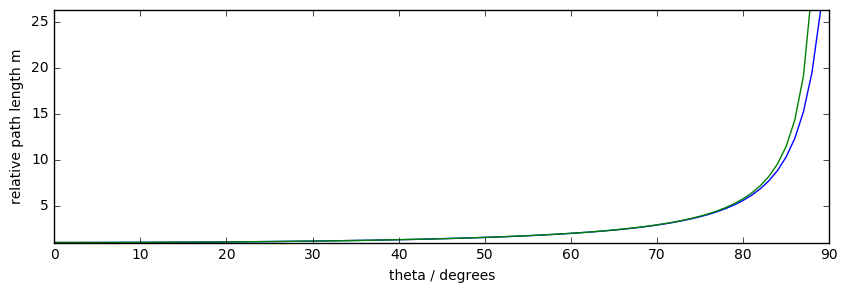

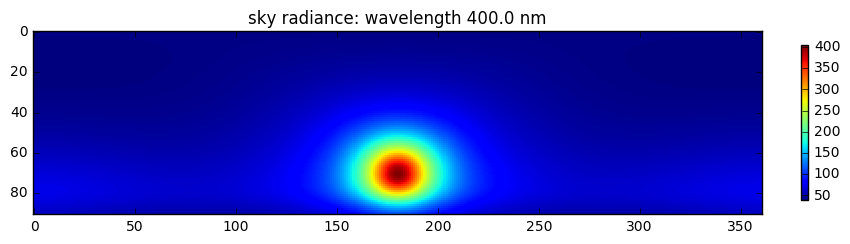

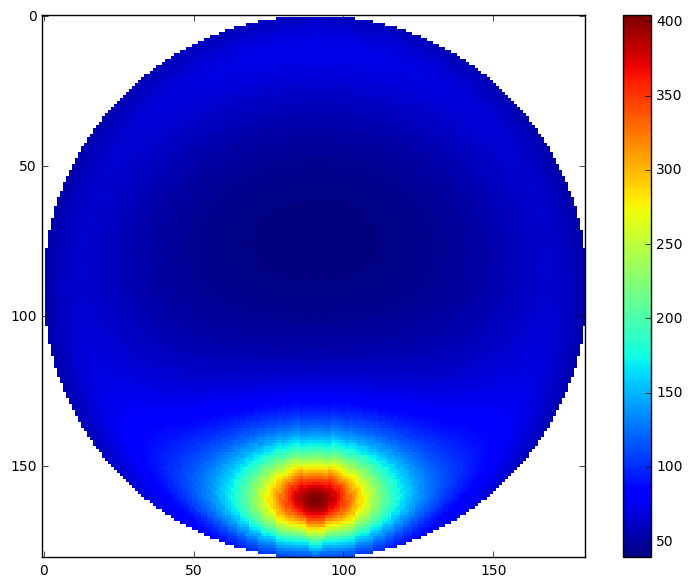

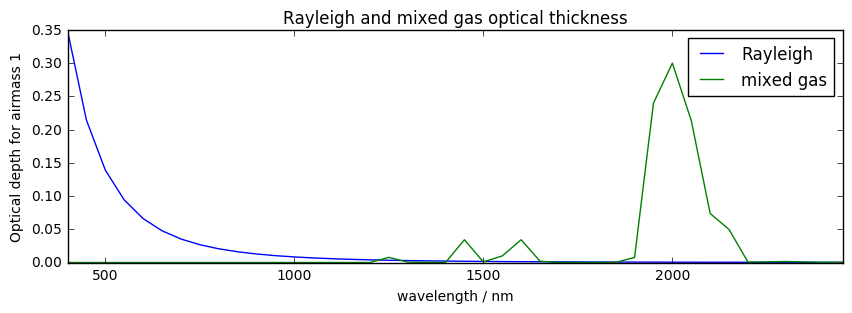

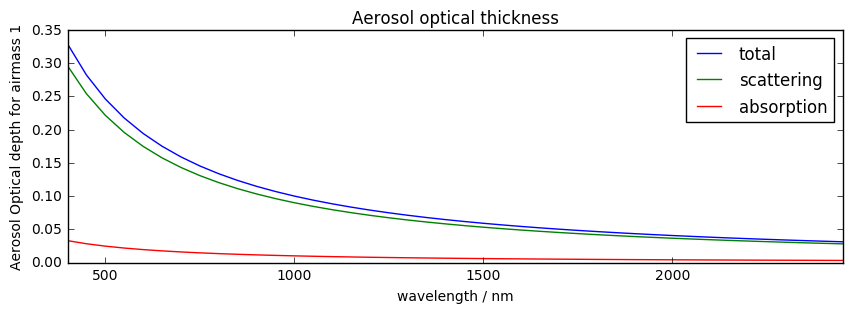

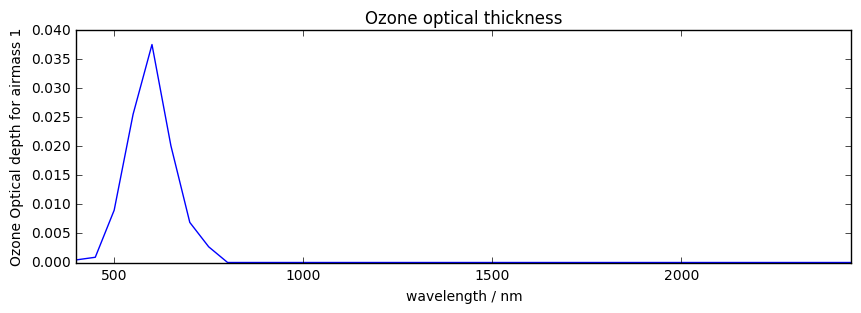

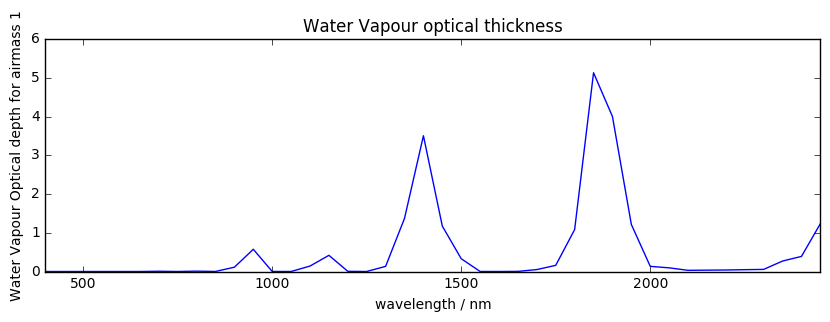

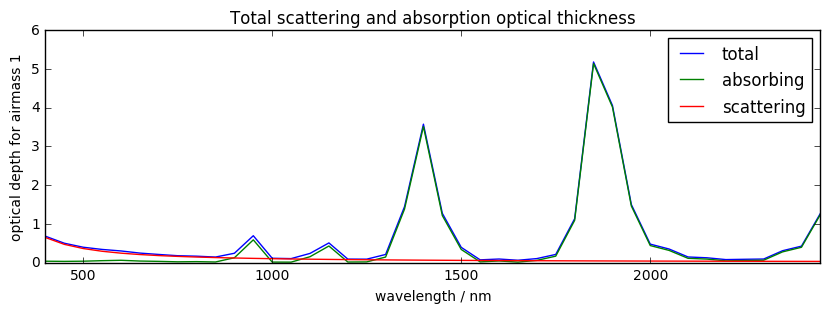

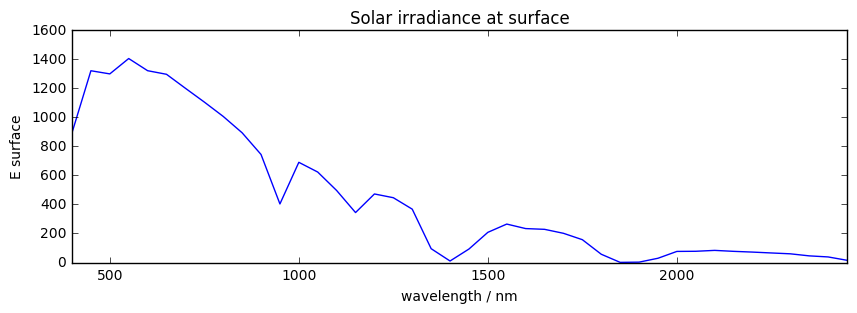

In [14]:
import numpy as np

LambdaCoefs = {'wl':(),'wavelengths':[],'angres':()}
RayleighCoefs={'A':None,'B':None,'C':None,'D':None,'Kg':None}
EODCoefs={'EOD':None}
WaterVapourCoefs={'Cw':None,'beta_0':None,'Td':None,'Kw':None}
AerosolCoefs={'omega_A':None,'alpha':None,'beta':None,'H_Penndorf':None}
AlbedoCoefs={'albedo':None}
TTHGCoefs={'g1':None,'g2':None,'alpha':None}
OzoneCoefs={'Co3':None,'b':None,'c':None,'Ko3':None}  

class Atmospheric(object):
            
    def __init__(self,doy=None,altitude=(),sza=None,LambdaCoefs=LambdaCoefs):

        '''
        Initiate class instance and set the following variables:
        
        doy        : day of year for simulation
        altitude   : ground and sensor altitude
        wavelength : wavelengths to process and angular resolution of output
        sza        : solar zenith angle (degrees)
        
        N.B. Wavelength is expected to be defined in nm. At one point in the code, we use
        analytical formulae for optical thickness terms. In that case, wavelength is
        defined in um (nm/1000) and appropriate units used (assuming they are defined here in nm)
        
        Parameters:

            altitude              : altitude[0]: ground
                                    altitude[1]: sensor
            doy                   : DOY (default 1)
            LambdaCoefs           : wl=(),wavelengths=[],angres=()

        '''
        self.doScaleHeight = False
        doyDefault = 1
        altitudeDefault = (None,None)
        szaDefault = 45.
        
        sza = sza or szaDefault
        self.doy = doy or doyDefault
        self.altitude    = tuple(altitude) + altitudeDefault[len(altitude):]
        self.wavelength  = Lambda(**LambdaCoefs)
        self.setSun(sza)
        
    def setSun(self,zenithDegrees,azimuthDegrees=0.):
        self.zenithDegrees = zenithDegrees
        self.azimuthDegrees = azimuthDegrees
        
    def calculateTerms(self,RayleighCoefs=RayleighCoefs,EODCoefs=EODCoefs,WaterVapourCoefs=WaterVapourCoefs,\
                 AerosolCoefs=AerosolCoefs,AlbedoCoefs=AlbedoCoefs,TTHGCoefs=TTHGCoefs,OzoneCoefs=OzoneCoefs):

        '''      
        - Interpolate all spectral terms to defined wavelengths (self.wavelength)
        - set scale heights if either of self.altitude[0] self.altitude[1] not None
        - calculate optical attenuation and scattering terms
        - set earth sun distance correction for E0
        - calculate Legendre coefficients (3)
        
        Options as dictionaries:

            RayleighCoefs          : A=None,B=None,C=None,D=None,Kg=None
            EODCoefs               : EOD=None
            WaterVapourCoefs       : Cw=None,beta_0=None,Td=None,Kw=None
            OzoneCoefs             : Co3=None,b=None,c=None,Ko3=None
            AerosolCoefs           : omega_A=None,alpha=None,beta=None,H_Penndorf=None
            AlbedoCoefs            : albedo=None 
            TTHGCoefs              : g1=None,g2=None,alpha=None
        '''
        wl = self.wavelength.l
        
        self.rayleigh = r = Rayleigh(**RayleighCoefs)
        f = scipy.interpolate.interp1d(r.KgOrig[0],r.KgOrig[1])
        self.rayleigh.Kg    = f(wl)
                
        self.eod       = r =  EOD(**EODCoefs)
        f = scipy.interpolate.interp1d(r.EODOrig[0],r.EODOrig[1])
        self.eod.EOD    = f(wl)

        self.waterVapour = r = WaterVapour(**WaterVapourCoefs)
        f = scipy.interpolate.interp1d(r.KwOrig[0],r.KwOrig[1])
        self.waterVapour.Kw    = f(wl)
        
        self.ozone       = r = Ozone(**OzoneCoefs)
        f = scipy.interpolate.interp1d(r.Ko3Orig[0],r.Ko3Orig[1])
        self.ozone.Ko3    = f(wl)
                
        self.albedo      = r = Albedo(**AlbedoCoefs)
        f = scipy.interpolate.interp1d(r.albedoOrig[0],r.albedoOrig[1])
        self.albedo.albedo    = f(wl)
        
        self.aerosol = r = Aerosol(**AerosolCoefs)
        
        self.tthg        = TTHG(**TTHGCoefs)
        
        # scale heights
        
        if (self.altitude[0] is not None) or (self.altitude[1] is not None):
            self.doScaleHeight = True
            
        self.setScaleHights()
            
        # calculate optical attenuation and scattering terms

        # NB wavelength in microns for these formulae
        wlu = wl/1000.
        exponent = -(self.rayleigh.B + self.rayleigh.C*wlu + self.rayleigh.D/wlu)
        self.tau_R = self.rayleigh.H * self.rayleigh.A  * (wlu**exponent)

        exponent = -self.aerosol.alpha
        self.tau_A = self.aerosol.H  * self.aerosol.beta * (wlu**exponent)

        self.tau_As = self.aerosol.omega_A * self.tau_A
        self.tau_Aa = (1.0 - self.aerosol.omega_A) * self.tau_A

        self.tau_O3 = self.ozone.H*self.ozone.Co3 * self.ozone.Ko3

        hconc = self.waterVapour.Cw * self.waterVapour.Kw * self.waterVapour.H
        self.tau_W = 0.2385 * hconc / ((1.0 + 20.07*hconc)**0.45)

        hconc = self.rayleigh.Kg * self.rayleigh.H
        self.tau_G = 1.41 * hconc / ((1.0 + 118.93*hconc)**0.45)
        
        # total abs and scattering terms

        self.tau_a = self.tau_O3 + self.tau_W + self.tau_G + self.tau_Aa
        self.tau_s = self.tau_R + self.tau_As
        
        # earth sun distance correction

        self.E = self.E_DOY(self.doy)     
        
    def createSkymap(self):
        theta0=np.deg2rad(self.zenithDegrees)
        cos_theta=cos_theta0=np.cos(theta0)
        sin_theta=sin_theta0=np.sin(theta0)
        phi0=np.deg2rad(self.azimuthDegrees)
        l = self.wavelength
        
        # plane parallel 
        #m=1.0/cos_theta
        # else use alternative
        m = self.m_Iqbal(self.zenithDegrees)
        
        dphi=(1.0/(self.wavelength.cols-1.))*np.pi*2.0
        dtheta=(1.0/(self.wavelength.rows-1.))*np.pi*0.5
        domega1=dtheta*dphi
        domega2=4.0*np.sin(dtheta/2.0)*np.sin(dphi/2.0)
        
        tau_T = self.tau_a + self.tau_s
        
        self.E_direct        = self.E * np.exp(-tau_T*m)
        self.E_direct_cosine = self.E_direct*cos_theta

        self.trans_down=np.exp(-tau_T/cos_theta);
        self.trans_up=np.exp(-tau_T)

        self.energy    = self.E * cos_theta/np.pi
        self.absorption= np.exp(-self.tau_a/cos_theta)

        self.edtheta = edtheta0 = np.exp(-self.tau_s/cos_theta);

        '''
        take account of Earth orbit about the Sun
        to find E0 for Julian day D
        '''
        self.Rtheta0  = 1.0 + 1.5*cos_theta + (1.0 - 1.5*cos_theta)*self.edtheta
        
        '''
        numerically evaluate first 3 terms of Legendre polymonial expansion
        '''
        self.legendre = self.Legendre(self.tau_R,self.tau_As,180/self.wavelength.angres[0])
        # here the shape of self.legendre[0] (and 1,2) is (nbands,)
        
        assert (self.wavelength.frames == self.legendre[0].shape[0])
        
        #
        # full frame calculations
        #
        
        phi, theta = np.mgrid[0:self.wavelength.cols,0:self.wavelength.rows]
        theta = (theta)*dtheta
        phi   = (phi)*dphi
        # in radians
        
        sin_theta = sin_theta1 = np.sin(theta)
        cos_theta = cos_theta1 = np.cos(theta)
        # avoid divide by zero
        cos_theta[np.abs(cos_theta)<1e-10] = 1e-10
        domega=sin_theta*domega2
        edtheta  = np.exp(-np.outer(self.tau_s,1./cos_theta)).reshape(self.tau_s.shape + cos_theta.shape)
        
        assert (edtheta.shape == (l.frames,l.cols,l.rows))
        
        self.Rtheta1  = self.R_aux(edtheta,cos_theta)
        self.sigma1   = self.Sigma1(self.tau_s,[theta0,theta],[edtheta0,edtheta],[cos_theta0,cos_theta])
        
        cos_phase_angle=self.CosPsi(theta,phi,theta0,phi0)
        cos2_phase_angle = cos_phase_angle*cos_phase_angle
        
        # Rayleigh scattering phase fn 
        p_R = self.rayleigh.Phase(cos2_phase_angle)
        # Aerosol scattering phase function
        p_A = self.tthg.Phase(cos_phase_angle)
        
        # scattering transmission coefficient of the atmosphere 
        self.scattering=self.Sigma(p_R,p_A,[cos_theta0,cos_theta],[edtheta0,edtheta],self.sigma1)
        self.lsky = self.Lsky(self.energy,self.scattering,self.absorption)
        self.theta = theta
        self.phi = phi
        

    def Sigma(self,p_R,p_A,cos_theta,edtheta,sigma1):
        # tau[i].tau_s,atmospheric_inputs->albedo.albedo[i],atmospheric_inputs->Legendre_coefficients[1],
        # tau[i].tau_R,tau[i].tau_As,p_R,p_A,cos_theta0,cos_theta,edtheta0,edtheta,Rtheta0,Rtheta,sigma1
        
        t2=0.5*(edtheta[1].T+edtheta[0]).T
        t31 = self.PF_Total(self.tau_R,p_R,self.tau_As,p_A).reshape(edtheta[1].shape)
        t32 = np.outer((3.0+self.legendre[1]),cos_theta[1]*cos_theta[0]).reshape(t31.shape)
        t3  = t31 - t32
        
        omr=1.0-self.albedo.albedo
        t10 = (self.Rtheta1.T * omr).T
        t11 = (t10.T + (2.0*self.albedo.albedo)).T
        t12 = (t11.T * self.Rtheta0).T
        num = 4.0+((3.0-self.legendre[1])*omr*self.tau_s)
        t1=(t12.T/num).T
        
        return(t1-t2+(t3*sigma1));
        
    def CosPsi(self,theta,phi,theta0,phi0):
        st=np.sin(theta);
        ct=np.cos(theta);
        st0=np.sin(theta0);
        ct0=np.cos(theta0);
        cos_of_angle=(ct*ct0)-(st*st0*np.cos(phi-phi0));
        cos_of_angle[cos_of_angle>1]=1
        cos_of_angle[cos_of_angle<-1]=-1
        
        return(cos_of_angle);
        
    def sigma1_ZV(self,edtheta,costheta):        
        numer=(edtheta[1].T-edtheta[0]).T
        denom=(costheta[1].T-costheta[0]).T
        # should already be checked so as not to == 0 */
        denom[np.abs(denom)<1e-10]=1e-10
        sigma1=0.25*numer/denom
        return sigma1

    def Legendre(self,tau_R,tau_As,dn):
        
        dtheta=np.pi/float(dn)
        theta = dtheta/2. + np.arange(dn)*dtheta
        Legendre_coeffs = np.zeros(3).astype(object)

        self.cost=cost=np.cos(theta);
        sint=np.sin(theta);
        self.cos2t=cos2t=cost*cost;
        sin2t=sint*sint;
        #
        # Rayleigh & Aerosol phase function components (independent of lambda)
        # 
        p_R = self.rayleigh.Phase(cos2t)  #  Rayleigh scattering phase fn 
        p_A = self.tthg.Phase(cost)     # Aerosol scattering phase function */
        p_T=self.PF_Total(tau_R, p_R, tau_As, p_A)
        pt=p_T*sint;
        Legendre_coeffs[0]+=pt
        Legendre_coeffs[1]+=(pt*cost)
        Legendre_coeffs[2]+=(pt*0.5*((3*cos2t)-1.0))
        
        Legendre_coeffs[0]*=0.5*dtheta; 
        Legendre_coeffs[1]*=1.5*dtheta; 
        Legendre_coeffs[2]*=dtheta;
        for i in xrange(3):
            Legendre_coeffs[i] = Legendre_coeffs[i].sum(axis=1)
            
        return Legendre_coeffs
    

    def Sigma1(self,tau_s,theta,edtheta,costheta):
        # code originally from (now) lost atmospheric code by A. Newton
        dtheta=0.01;
        cosdiff=costheta[1]-costheta[0]

        ww = np.abs(cosdiff)<0.00001
        # linearly interpolate sigma1 from interval +/- dtheta on either side of theta0 
        ctp1=np.cos(theta[1]+dtheta);
        ctm1=np.cos(theta[1]-dtheta);
        ep1=np.exp(-np.outer(tau_s,1./ctp1))
        ep1 = ep1.reshape((ep1.shape[0],)+ctp1.shape)
        em1=np.exp(-np.outer(tau_s,1./ctm1)).reshape(ep1.shape)
        ep0=em0=edtheta[0]
        
        ctp0=ctm0=costheta[0];
        sp=self.sigma1_ZV([ep0,ep1],[ctp0,ctp1]);
        sm=self.sigma1_ZV([em0,em1],[ctm0,ctm1]);

        sigma1 = np.zeros(ep1.shape)
        sigma1[:,ww]  = (sm[:,ww]+sp[:,ww])/2.0;
        sigma1[:,~ww] = self.sigma1_ZV(edtheta,costheta)[:,~ww]
        #sigma1 = self.sigma1_ZV(edtheta,costheta)
        return(sigma1);

    def PF_Total(self,tau_R, p_R, tau_As, p_A):
        #out = (tau_R*p_R + tau_As*p_A)/(tau_R+tau_As);
        out = (np.outer(tau_R,p_R) + np.outer(tau_As,p_A)).T/(tau_R+tau_As)
        return(out.T);
        
    
    def E_DOY(self,D):
        '''
        Earth Sun distance attenuation of E0
        for day of year D
        
        '''
        d=2.0*np.pi*(D-3)/365.0
        t=0.01672*np.cos(d) + 1.0
        return(self.eod.EOD*t*t)
    
    def m_Iqbal(self,theta): # in degrees 
        '''
        sensible path length behaviour
        '''
        a=93.885-theta;

        b=0.15*(a**(-1.253));

        out=1.0/(np.cos(np.pi*(theta)/180.)+b);

        return(out)
    
    def setScaleHights(self):
        '''
        Calculate scale heights for Rayleigh
        Aerosols, Ozone and water vapour
        
        based on self.altitude
        
        '''
        if self.doScaleHeight:
            '''
            model scale heights (normal incidence)
            '''
            self.rayleigh.H    = self.rayleigh.scaleHeight(self.altitude)
            self.aerosol.H     = self.aerosol.scaleHeight(self.altitude)
            self.ozone.H       = self.ozone.scaleHeight(self.altitude)
            self.waterVapour.H = self.waterVapour.scaleHeight(self.altitude)
        else:
            self.rayleigh.H=self.aerosol.H=self.ozone.H=self.waterVapour.H = 1.0

    def R_aux(self,edtheta,cos_theta):
        return 1.0 + 1.5*cos_theta + (1.0 - 1.5*cos_theta)*edtheta;

    def Phase(self,p_R,p_A):
        '''
        Total phase function
        
        pR  : Rayleigh phase
        pA  : aerosol phase
        '''
        out = (self.optical.tau_R*p_R + self.optical.tau_As*p_A)\
                    /(self.optical.tau_R+self.optical.tau_As);

        return(out)
    
    def Lsky(self,energy,sigma_scat,absorption):      
        return((sigma_scat.T * (energy*absorption)).T)
    
    def displayLsky(self,band=0):
        nbands,ncols,nrows = self.lsky.shape
        lsky = self.lsky
        '''plt.figure(figsize=(10,3))
        plt.plot(self.wavelength.l,lsky.sum(axis=(1,2)))'''
        plt.figure(figsize=(10,7))
        plt.imshow(lsky[band].T,interpolation='nearest')
        plt.colorbar(fraction=0.01)
        plt.title('sky radiance: wavelength %5.1f nm'%self.wavelength.l[band])
        
    def mapLskyToCircle(self,size=None,band=0):
        nbands,ncols,nrows = self.lsky.shape
        lsky = self.lsky[band]
        if size == None:
            size = int(np.sqrt(ncols*nrows))
        r,c = np.mgrid[0:size,0:size]
        r = r.astype(float)
        c = c.astype(float)
        centre = size/2.
        dr = r - centre
        dc = c - centre
        lphi = np.arctan2(dr,dc).T
        # so ltheta is between 0 and 1
        ltheta = 2*np.sqrt(dr*dr+dc*dc)/size
        mask = ltheta>1.0
        # mask > 1. or use domega?
        
        
        lphi[mask] = np.nan
        phimax = lphi[ltheta<=1.0].max()
        phimin = lphi[ltheta<=1.0].min()
        lphi = -(lphi+phimin)/(phimax-phimin)
        ltheta[mask] = np.nan
        ltheta = (ltheta)
        
        # so now convert lphi and ltheta to row,col
        ltheta = (ltheta * nrows).astype(int)
        ltheta[ltheta>=nrows]=nrows-1
        ltheta[ltheta<0]=0
        lphi = (lphi * ncols).astype(int)
        lphi[lphi>=ncols]=ncols-1
        lphi[lphi<0]=0

        rows = ltheta.flatten()
        cols = lphi.flatten()
        smap = np.array([lsky[r,c] for r,c in zip(cols,rows)]).reshape(lphi.shape)
        smap[mask] = np.nan
        plt.figure(figsize=(10,7))
        plt.imshow(smap,interpolation='nearest')
        plt.colorbar()
        '''plt.figure(figsize=(10,7))
        plt.imshow(lphi,interpolation='nearest')
        plt.colorbar()
        plt.figure(figsize=(10,7))
        plt.imshow(ltheta,interpolation='nearest')
        plt.colorbar()'''

def main():
    LambdaCoefs = {'wl':(400.,2500,50),'wavelengths':[],'angres':(1,1)}
    r=Atmospheric(LambdaCoefs=LambdaCoefs,sza=70)
    r.calculateTerms()
    r.createSkymap()
    
    plt.figure(figsize=(10,3))
    theta = np.arange(90);
    m=r.m_Iqbal(theta)
    plt.plot(theta,m)
    plt.ylim(m.min(),m.max())
    plt.plot(theta,1./np.cos(theta*np.pi/180.))
    plt.xlabel('theta / degrees')
    plt.ylabel('relative path length m')
    
    r.displayLsky()
    
    r.mapLskyToCircle()
    
    wl = r.wavelength.l
        
    # do some plotting
    
    plt.figure(figsize=(10,3))
    plt.plot(wl,r.tau_R,label='Rayleigh')
    plt.plot(wl,r.tau_G,label='mixed gas')
    plt.xlim(wl[0],wl[-1])
    plt.xlabel('wavelength / nm')
    plt.ylabel('Optical depth for airmass 1')
    plt.title('Rayleigh and mixed gas optical thickness')
    plt.legend(loc='best')
    print 'compare Rayleigh with "Frohlich and Shaw, p. 1774 APPLIED OPTICS/ Vol. 19, No. 11 / 1 June 1980"'
    #r.tester()
    plt.figure(figsize=(10,3))
    plt.plot(wl,r.tau_A,label='total')
    plt.plot(wl,r.tau_As,label='scattering')
    plt.plot(wl,r.tau_Aa,label='absorption')    
    plt.xlim(wl[0],wl[-1])
    plt.xlabel('wavelength / nm')
    plt.ylabel('Aerosol Optical depth for airmass 1')
    plt.title('Aerosol optical thickness')  
    plt.legend(loc='best')
    
    plt.figure(figsize=(10,3))
    plt.plot(wl,r.tau_O3)
    plt.xlim(wl[0],wl[-1])
    plt.xlabel('wavelength / nm')
    plt.ylabel('Ozone Optical depth for airmass 1')
    plt.title('Ozone optical thickness')    
    
    plt.figure(figsize=(10,3))
    plt.plot(wl,r.tau_W)
    plt.xlim(wl[0],wl[-1])
    plt.xlabel('wavelength / nm')
    plt.ylabel('Water Vapour Optical depth for airmass 1')
    plt.title('Water Vapour optical thickness')    
    
    plt.figure(figsize=(10,3))
    plt.plot(wl,r.tau_s+r.tau_a,label='total')  
    plt.plot(wl,r.tau_a,label='absorbing')
    plt.plot(wl,r.tau_s,label='scattering')    
    plt.xlim(wl[0],wl[-1])
    plt.xlabel('wavelength / nm')
    plt.ylabel('optical depth for airmass 1')
    plt.title('Total scattering and absorption optical thickness')        
    # total abs and scattering terms
    plt.legend(loc='best')
        
    tau_T = r.tau_a + r.tau_s
    E_direct = r.E * np.exp(-tau_T)
    plt.figure(figsize=(10,3))
    plt.plot(wl,E_direct)
    plt.xlim(wl[0],wl[-1])
    plt.xlabel('wavelength / nm')
    plt.title('Solar irradiance at surface')
    plt.ylabel('E surface')         

    
    # so what size dataset
    print r.wavelength.rows,r.wavelength.cols,r.wavelength.frames

if __name__ == "__main__":
    main()

In [15]:
LambdaCoefs = {'wl':(),'wavelengths':[],'angres':()}
RayleighCoefs={'A':None,'B':None,'C':None,'D':None,'Kg':None}
EODCoefs={'EOD':None}
WaterVapourCoefs={'Cw':None,'beta_0':None,'Td':None,'Kw':None}
AerosolCoefs={'omega_A':None,'alpha':None,'beta':None,'H_Penndorf':None}
AlbedoCoefs={'albedo':None}
TTHGCoefs={'g1':None,'g2':None,'alpha':None}
OzoneCoefs={'Co3':None,'b':None,'c':None,'Ko3':None} 

LambdaCoefs = {'wl':(400.,2500,50),'wavelengths':[],'angres':(1,1)}

for i in np.arange(360)[::-1]:
    sza = i*0.25-0.00000001
    print i,'%4.2f'%sza,
    r=Atmospheric(LambdaCoefs=LambdaCoefs,sza=sza)
    r.calculateTerms()
    r.createSkymap()

    r.displayLsky()
    plt.close()
    r.mapLskyToCircle()
    plt.savefig('.images/frame%60d.png'%(360-i))
    plt.close()

359 89.74999999 358 89.49999999 357 89.24999999 356 88.99999999 355 88.74999999 354 88.49999999 353 88.24999999 352 87.99999999 351 87.74999999 350 87.49999999 349 87.24999999 348 86.99999999 347 86.74999999 346 86.49999999 345 86.24999999 344 85.99999999 343 85.74999999 342 85.49999999 341 85.24999999 340 84.99999999 339 84.74999999 338 84.49999999 337 84.24999999 336 83.99999999 335 83.74999999 334 83.49999999 333 83.24999999 332 82.99999999 331 82.74999999 330 82.49999999 329 82.24999999 328 81.99999999 327 81.74999999 326 81.49999999 325 81.24999999 324 80.99999999 323 80.74999999 322 80.49999999 321 80.24999999 320 79.99999999 319 79.74999999 318 79.49999999 317 79.24999999 316 78.99999999 315 78.74999999 314 78.49999999 313 78.24999999 312 77.99999999 311 77.74999999 310 77.49999999 309 77.24999999 308 76.99999999 307 76.74999999 306 76.49999999 305 76.24999999 304 75.99999999 303 75.74999999 302 75.49999999 301 75.24999999 300 74.99999999 299 74.74999999 298 74.49999999 297 74.2

In [16]:
!convert -delay 10 -loop 0 .images/*png movie.gif 
